In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import params
import nucleation_and_growth as nandg

Pr =  0.09075  Sc =  999.9999999999999


# Crystal growth following Sun et al. (2018)

The Kirkpatrick growth models assume that the process of crystal growth at an interface can be described
in terms of a diffusional equation and treated as if this was solving a bulk diffusion problem (i.e. that
the Stokes-Einstien equation holds). This seems unlikly. Fortunatly, more recent work has 
attempted to quantify and understand crystal growth in metals using atomic scale simulation. Importantly,
this is a very quick process.

Here we follow Sun et al. (2018; Nature Materials 17:881-886, https://doi.org/10.1038/s41563-018-0174-6)
who simulate crystal growth of the FCC metals Al, Ni, Cu, Ag, Pt and Pb using an embedded atom model at
temperatures from the (simulated) melting point down to undercoolings of ~300 K below the melting point in order
to understand why crystal growth for these crystals was "ultrafast". These calculations were undertaken
using LAMMPS and were not at elevated pressure. These atomic scale results were compared with three models
and an emprical fit:

1. A linear fit of growth rate againts undercooling
2. The Wilson–Frenkel model, where growth is limited by diffusion in the liquid
3. A Ginzburg–Landau approach, where growth is contolled by density fluctuations in the liquid
4. A collision rate model

All these models can be described the interaction of a kinetic and a thermodynamic term (equation 1 of Sun; S1):

$$ V(T) = k(T) \left[1 - \exp\left(\frac{\Delta\mu}{k_B T}\right)  \right],$$

where $V(T)$ is the growth rate of the crystal (normal to the 111 face) $k(T)$ is a kinetic function and
$\Delta\mu$ is the difference in the chemical potential of the solid and theliquid. This is analogous to K4,
(or K8). $k(T)$ is different for the different models:

1. $k(T) = k_0$
2. $k(T) = l\frac{6D(T)}{\gamma^2}$
3. $k(T) \propto \frac{S(K_i)}{\tau(K_i)}$
3. $k(T) \propto \sqrt{\frac{3K_B T}{M}}$

Models 1 and 4 reproduce the atomic scale data fairly well over the temperature range (see Sun et al. Fig 1).

For simplicity, I'll take model 1 and write a growth rate function.

Sun SI: https://static-content.springer.com/esm/art%3A10.1038%2Fs41563-018-0174-6/MediaObjects/41563_2018_174_MOESM1_ESM.pdf

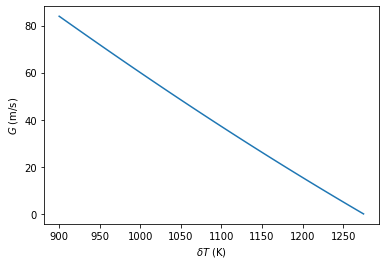

In [2]:
# Calculate growth velocity as a function of temperatue 
ts_ = np.linspace(900, params.cu_tm)
dts = params.cu_tm - ts_
vs  = nandg.sun_velocity_fit(dts, params.cu_tm, params.cu_dhm, params.cu_k0)

# Plot graph - like Fig 1 of paper
fig, ax = plt.subplots()
ax.plot(ts_, vs)
#ax.plot(dts, vs)
ax.set_xlabel('$\delta T$ (K)')
ax.set_ylabel('$G$ (m/s)')
#ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
file2="Sun.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")
plt.show()

## Nucleation timescale

Uses eqn 6 of https://www.sciencedirect.com/science/article/pii/S0012821X18306782

In [3]:
T_abs   = np.linspace(4500, 6500, 11)
O_abs   = np.linspace(0.01, 0.08, 11)
tN      = np.zeros([len(T_abs), len(O_abs)])
tG      = np.zeros([len(T_abs), len(O_abs)])
ttot_TO = np.zeros([len(T_abs), len(O_abs)])

rad   = 1e-6

ttot_To, tN, tG = nandg.tau_phase_TO(rad, T_abs, O_abs)

/Users/andrewwalker/Code/slurry/nucleation_and_growth.py:37: RuntimeWarning: overflow encountered in exp
  tau_v = prefac * np.exp(fac)


In [4]:
r = np.logspace(-8,3,num=100)
Temp = [5150,5250, 5150, 5250]
Oconc= [0.01, 0.01, 0.02, 0.02]
ttot_r = [] # List to hold results...
for i, o in zip(Temp, Oconc):
    ttot_r.append(nandg.tau_phase_r(r, i, o))

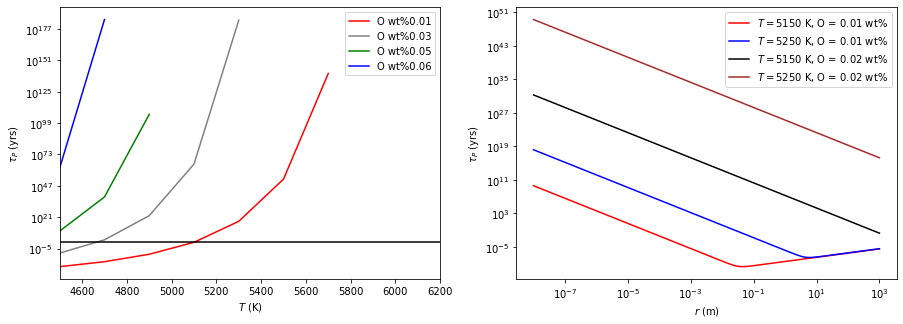

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_yscale('log')
ax1.set_xlabel('$T$ (K)')
ax1.set_ylabel('$\\tau_P$ (yrs)')
ax1.set_xlim([4500,6200])
ax1.plot(T_abs, tN[:,0]  , color='red'   ,label="O wt%"+str(np.round(O_abs[0],2)))
ax1.plot(T_abs, tN[:,3]  , color='grey',label="O wt%"+str(np.round(O_abs[3],2)))
ax1.plot(T_abs, tN[:,5]  , color='green' ,label="O wt%"+str(np.round(O_abs[5],2)))
ax1.plot(T_abs, tN[:,7]  , color='blue'  ,label="O wt%"+str(np.round(O_abs[7],2)))
ax1.plot(T_abs, ttot_TO[:,0], color='red'   , ls=':')
ax1.plot(T_abs, ttot_TO[:,3], color='grey', ls=':')
ax1.plot(T_abs, ttot_TO[:,5], color='green' , ls=':')
ax1.plot(T_abs, ttot_TO[:,7], color='blue'  , ls=':')
ax1.plot(T_abs, np.ones(len(T_abs)), color="black")
ax1.legend()

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('$r$ (m)')
ax2.set_ylabel('$\\tau_P$ (yrs)')
for ttr, tmp, oco, col in zip(ttot_r, Temp, Oconc, ['red', 'blue', 'black', 'brown']):
    ax2.plot(r, ttr  , color=col  , label="$T={}$ K, O = {} wt%".format(tmp, oco))
ax2.legend()

file2="Tp.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

plt.show()